In [1]:
%matplotlib inline
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [2]:
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import xarray as xr
import torch
import nibabel as nib

sys.path.append('..')
import project

torch.cuda.is_available()

True

In [3]:
%autoreload
dataset = project.copdgene.COPDGene(data_root='../data/COPDGene')
dataset

COPDGene(data_root=../data/COPDGene, #subjects=115)

In [4]:
image_dir = 'Resized'
mask_dir  = 'TotalSegment'
disp_dir  = 'CorrField'

In [5]:
visit = dataset[0][0]
visit

COPDGeneVisit(data_root=../data/COPDGene, subject_id=10009Y, visit_name=Phase-1)

In [6]:
images = visit.load_images(image_dir, pattern='*_EXP_*')
len(images)

Loading ../data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_EXP_SHARP_NJC_COPD.nii.gz
../data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_EXP_SHARP_NJC_COPD.nii.gz (256, 256, 256)
Loading ../data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_EXP_STD_NJC_COPD.nii.gz
../data/COPDGene/Images/10009Y/Phase-1/Resized/10009Y_EXP_STD_NJC_COPD.nii.gz (256, 256, 256)


2

In [7]:
xview = project.visual.view

interactive(children=(Output(),), _dom_classes=('widget-interact',))

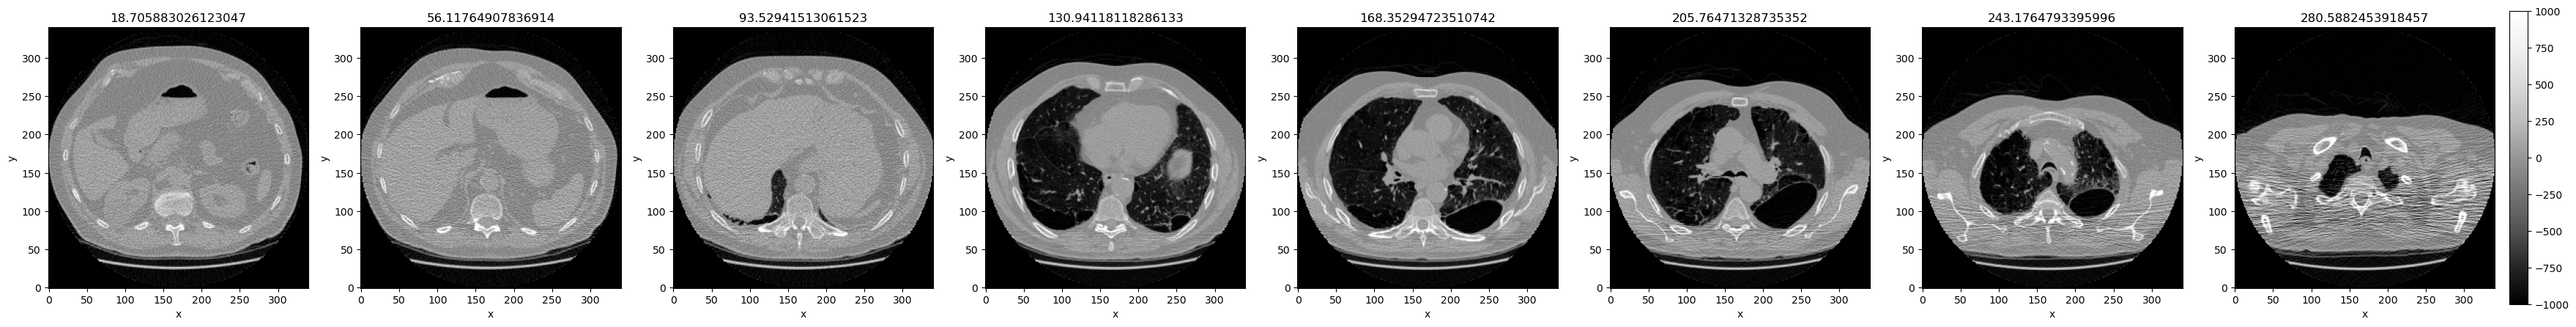

In [8]:
xview(images[1][:,:,16::32], cmap='Greys_r', vmin=-1000, vmax=1000, col='z', space=0.2)

In [31]:
sys.path.append('../../Lung250M-4B')
from corrfield.corrfield import corrfield

In [44]:
%%time
validate_only = True

for i, subject in list(enumerate(dataset.subjects))[19:]:
    for j, visit in enumerate(subject.visits):
        for k, fix_image_name in enumerate(visit.list_images(image_dir)):
            print((i,j,k), visit.subject_id, visit.visit_name, fix_image_name)

            if '_EXP_' in fix_image_name:
                mov_image_name = fix_image_name.replace('_EXP_', '_INSP_')
            elif '_INSP_' in fix_image_name:
                mov_image_name = fix_image_name.replace('_INSP_', '_EXP_')

            mov_image_file = visit.image_file(image_dir, mov_image_name)
            fix_image_file = visit.image_file(image_dir, fix_image_name)
            fix_mask_file  = visit.mask_file(mask_dir, fix_image_name, roi='lung_combined_mask')
            disp_file  = visit.disp_file(disp_dir, fix_image_name, mov_image_name)
            try:
                assert fix_image_file.exists(), fix_image_file
                assert mov_image_file.exists(), mov_image_file
                assert fix_mask_file.exists(), fix_mask_file

                if not validate_only:
                    mov_image = nib.load(mov_image_file)
                    fix_image = nib.load(fix_image_file)
                    fix_mask  = nib.load(fix_mask_file)
                    disp = corrfield(
                        img_mov=torch.as_tensor(mov_image.get_fdata(), dtype=torch.float).unsqueeze(0).unsqueeze(0).cuda(),
                        img_fix=torch.as_tensor(fix_image.get_fdata(), dtype=torch.float).unsqueeze(0).unsqueeze(0).cuda(),
                        mask_fix=torch.as_tensor(fix_mask.get_fdata(), dtype=torch.float).unsqueeze(0).unsqueeze(0).cuda(),
                    )[0][0].detach().cpu().numpy()
                    print(disp.shape)

                    resolution = fix_image.header.get_zooms()
                    affine = np.diag(list(resolution) + [1])
                    disp_file.parent.mkdir(exist_ok=True, parents=True)
                    nib.save(nib.nifti1.Nifti1Image(disp, affine), disp_file)

                assert disp_file.exists(), disp_file
            except Exception as e:
                print(e, file=sys.stderr)
                continue


(19, 0, 0) 11771K Phase-1 11771K_INSP_SHARP_COL_COPD
(19, 0, 1) 11771K Phase-1 11771K_INSP_STD_COL_COPD
(20, 0, 0) 11919Q Phase-1 11919Q_EXP_SHARP_PIT_COPD
(20, 0, 1) 11919Q Phase-1 11919Q_EXP_STD_PIT_COPD
(20, 0, 2) 11919Q Phase-1 11919Q_INSP_SHARP_PIT_COPD
(20, 0, 3) 11919Q Phase-1 11919Q_INSP_STD_PIT_COPD
(21, 0, 0) 12058V Phase-1 12058V_EXP_SHARP_MSM_COPD
(21, 0, 1) 12058V Phase-1 12058V_EXP_STD_MSM_COPD
(21, 0, 2) 12058V Phase-1 12058V_INSP_SHARP_MSM_COPD
(21, 0, 3) 12058V Phase-1 12058V_INSP_STD_MSM_COPD
(22, 0, 0) 12140G Phase-1 12140G_EXP_SHARP_HAR_COPD
(22, 0, 1) 12140G Phase-1 12140G_EXP_STD_HAR_COPD


../data/COPDGene/Images/11771K/Phase-1/Resized/11771K_EXP_SHARP_COL_COPD.nii.gz
../data/COPDGene/Images/11771K/Phase-1/Resized/11771K_EXP_STD_COL_COPD.nii.gz


(22, 0, 2) 12140G Phase-1 12140G_INSP_SHARP_HAR_COPD
(22, 0, 3) 12140G Phase-1 12140G_INSP_STD_HAR_COPD
(23, 0, 0) 12167A Phase-1 12167A_EXP_SHARP_TEM_COPD
(23, 0, 1) 12167A Phase-1 12167A_EXP_STD_TEM_COPD
(23, 0, 2) 12167A Phase-1 12167A_INSP_SHARP_TEM_COPD
(23, 0, 3) 12167A Phase-1 12167A_INSP_STD_TEM_COPD
(24, 0, 0) 12180S Phase-1 12180S_EXP_B35f_UIA_COPD
(24, 0, 1) 12180S Phase-1 12180S_EXP_SHARP_UIA_COPD
(24, 0, 2) 12180S Phase-1 12180S_EXP_STD_UIA_COPD
(24, 0, 3) 12180S Phase-1 12180S_INSP_B35f_UIA_COPD
(24, 0, 4) 12180S Phase-1 12180S_INSP_SHARP_UIA_COPD
(24, 0, 5) 12180S Phase-1 12180S_INSP_STD_UIA_COPD
(25, 0, 0) 12200Y Phase-1 12200Y_EXP_SHARP_TEM_COPD
(25, 0, 1) 12200Y Phase-1 12200Y_EXP_STD_TEM_COPD
(25, 0, 2) 12200Y Phase-1 12200Y_INSP_SHARP_TEM_COPD
(25, 0, 3) 12200Y Phase-1 12200Y_INSP_STD_TEM_COPD
(26, 0, 0) 12313L Phase-1 12313L_EXP_SHARP_NJC_COPD
(26, 0, 1) 12313L Phase-1 12313L_EXP_STD_NJC_COPD
(26, 0, 2) 12313L Phase-1 12313L_INSP_SHARP_NJC_COPD
(26, 0, 3) 12313L Ph

../data/COPDGene/Images/12723E/Phase-1/Resized/12723E_EXP_SHARP_COL_COPD.nii.gz
../data/COPDGene/Images/12723E/Phase-1/Resized/12723E_EXP_STD_COL_COPD.nii.gz


(31, 0, 1) 12851N Phase-1 12851N_EXP_STD_UAB_COPD
(31, 0, 2) 12851N Phase-1 12851N_INSP_SHARP_UAB_COPD
(31, 0, 3) 12851N Phase-1 12851N_INSP_STD_UAB_COPD
(32, 0, 0) 12967G Phase-1 12967G_EXP_SHARP_NJC_COPD
(32, 0, 1) 12967G Phase-1 12967G_EXP_STD_NJC_COPD
(32, 0, 2) 12967G Phase-1 12967G_INSP_SHARP_NJC_COPD
(32, 0, 3) 12967G Phase-1 12967G_INSP_STD_NJC_COPD
(33, 0, 0) 13071S Phase-1 13071S_EXP_SHARP_JHU_COPD
(33, 0, 1) 13071S Phase-1 13071S_EXP_STD_JHU_COPD
(33, 0, 2) 13071S Phase-1 13071S_INSP_SHARP_JHU_COPD
(33, 0, 3) 13071S Phase-1 13071S_INSP_STD_JHU_COPD
(34, 0, 0) 13450A Phase-1 13450A_EXP_SHARP_BWH_COPD
(34, 0, 1) 13450A Phase-1 13450A_EXP_STD_BWH_COPD
(34, 0, 2) 13450A Phase-1 13450A_INSP_SHARP_BWH_COPD
(34, 0, 3) 13450A Phase-1 13450A_INSP_STD_BWH_COPD
(35, 0, 0) 13540B Phase-1 13540B_EXP_SHARP_NJC_COPD
(35, 0, 1) 13540B Phase-1 13540B_EXP_STD_NJC_COPD
(35, 0, 2) 13540B Phase-1 13540B_INSP_SHARP_NJC_COPD
(35, 0, 3) 13540B Phase-1 13540B_INSP_STD_NJC_COPD
(36, 0, 0) 13575U Phas

../data/COPDGene/Images/13990G/Phase-1/Resized/13990G_EXP_SHARP_COL_COPD.nii.gz
../data/COPDGene/Images/13990G/Phase-1/Resized/13990G_EXP_STD_COL_COPD.nii.gz
../data/COPDGene/Images/14136Z/Phase-1/Resized/14136Z_EXP_SHARP_COL_COPD.nii.gz
../data/COPDGene/Images/14136Z/Phase-1/Resized/14136Z_EXP_STD_COL_COPD.nii.gz


(42, 0, 0) 14293P Phase-1 14293P_EXP_SHARP_PIT_COPD
(42, 0, 1) 14293P Phase-1 14293P_EXP_STD_PIT_COPD
(42, 0, 2) 14293P Phase-1 14293P_INSP_SHARP_PIT_COPD
(42, 0, 3) 14293P Phase-1 14293P_INSP_STD_PIT_COPD
(43, 0, 0) 14402U Phase-1 14402U_EXP_SHARP_UMN_COPD
(43, 0, 1) 14402U Phase-1 14402U_EXP_STD_UMN_COPD
(43, 0, 2) 14402U Phase-1 14402U_INSP_SHARP_UMN_COPD
(43, 0, 3) 14402U Phase-1 14402U_INSP_STD_UMN_COPD
(44, 0, 0) 14449U Phase-1 14449U_EXP_SHARP_BWH_COPD
(44, 0, 1) 14449U Phase-1 14449U_EXP_STD_BWH_COPD
(44, 0, 2) 14449U Phase-1 14449U_INSP_SHARP_BWH_COPD
(44, 0, 3) 14449U Phase-1 14449U_INSP_STD_BWH_COPD
(45, 0, 0) 14790D Phase-1 14790D_EXP_SHARP_HVA_COPD
(45, 0, 1) 14790D Phase-1 14790D_EXP_STD_HVA_COPD
(45, 0, 2) 14790D Phase-1 14790D_INSP_SHARP_HVA_COPD
(45, 0, 3) 14790D Phase-1 14790D_INSP_STD_HVA_COPD
(46, 0, 0) 14834X Phase-1 14834X_EXP_SHARP_FAL_COPD
(46, 0, 1) 14834X Phase-1 14834X_EXP_STD_FAL_COPD
(46, 0, 2) 14834X Phase-1 14834X_INSP_SHARP_FAL_COPD
(46, 0, 3) 14834X Pha

../data/COPDGene/Images/15626V/Phase-1/Resized/15626V_EXP_SHARP_TXS_COPD.nii.gz
../data/COPDGene/Images/15626V/Phase-1/Resized/15626V_EXP_STD_TXS_COPD.nii.gz


(52, 0, 2) 15808B Phase-1 15808B_INSP_SHARP_TEM_COPD
(52, 0, 3) 15808B Phase-1 15808B_INSP_STD_TEM_COPD
(53, 0, 0) 15840X Phase-1 15840X_EXP_SHARP_NJC_COPD
(53, 0, 1) 15840X Phase-1 15840X_EXP_STD_NJC_COPD
(53, 0, 2) 15840X Phase-1 15840X_INSP_SHARP_NJC_COPD
(53, 0, 3) 15840X Phase-1 15840X_INSP_STD_NJC_COPD
(54, 0, 0) 15883P Phase-1 15883P_EXP_SHARP_BAY_COPD
(54, 0, 1) 15883P Phase-1 15883P_EXP_STD_BAY_COPD
(54, 0, 2) 15883P Phase-1 15883P_INSP_SHARP_BAY_COPD
(54, 0, 3) 15883P Phase-1 15883P_INSP_STD_BAY_COPD
(55, 0, 0) 15914A Phase-1 15914A_EXP_B35f_UIA_COPD
(55, 0, 1) 15914A Phase-1 15914A_EXP_SHARP_UIA_COPD
(55, 0, 2) 15914A Phase-1 15914A_EXP_STD_UIA_COPD
(55, 0, 3) 15914A Phase-1 15914A_INSP_B35f_UIA_COPD
(55, 0, 4) 15914A Phase-1 15914A_INSP_SHARP_UIA_COPD
(55, 0, 5) 15914A Phase-1 15914A_INSP_STD_UIA_COPD
(56, 0, 0) 16463Y Phase-1 16463Y_EXP_SHARP_NJC_COPD
(56, 0, 1) 16463Y Phase-1 16463Y_EXP_STD_NJC_COPD
(56, 0, 2) 16463Y Phase-1 16463Y_INSP_SHARP_NJC_COPD
(56, 0, 3) 16463Y Ph

../data/COPDGene/Images/21410K/Phase-1/Resized/21410K_EXP_SHARP_COL_COPD.nii.gz


(86, 0, 3) 21532Y Phase-1 21532Y_INSP_B35f_UIA_COPD
(86, 0, 4) 21532Y Phase-1 21532Y_INSP_SHARP_UIA_COPD
(86, 0, 5) 21532Y Phase-1 21532Y_INSP_STD_UIA_COPD
(87, 0, 0) 21589B Phase-1 21589B_EXP_SHARP_TXS_COPD
(87, 0, 1) 21589B Phase-1 21589B_EXP_STD_TXS_COPD
(87, 0, 2) 21589B Phase-1 21589B_INSP_SHARP_TXS_COPD
(87, 0, 3) 21589B Phase-1 21589B_INSP_STD_TXS_COPD
(88, 0, 0) 21737Q Phase-1 21737Q_EXP_B35f_UIA_COPD
(88, 0, 1) 21737Q Phase-1 21737Q_EXP_SHARP_UIA_COPD
(88, 0, 2) 21737Q Phase-1 21737Q_EXP_STD_UIA_COPD
(88, 0, 3) 21737Q Phase-1 21737Q_INSP_B35f_UIA_COPD
(88, 0, 4) 21737Q Phase-1 21737Q_INSP_SHARP_UIA_COPD
(88, 0, 5) 21737Q Phase-1 21737Q_INSP_STD_UIA_COPD
(89, 0, 0) 21956C Phase-1 21956C_EXP_SHARP_UMC_COPD
(89, 0, 1) 21956C Phase-1 21956C_EXP_STD_UMC_COPD
(89, 0, 2) 21956C Phase-1 21956C_INSP_SHARP_UMC_COPD
(89, 0, 3) 21956C Phase-1 21956C_INSP_STD_UMC_COPD
(90, 0, 0) 22182C Phase-1 22182C_EXP_B35f_NJC_COPD
(90, 0, 1) 22182C Phase-1 22182C_EXP_SHARP_NJC_COPD
(90, 0, 2) 22182C Ph

../data/COPDGene/Images/22827W/Phase-1/Resized/22827W_EXP_SHARP_COL_COPD.nii.gz


(98, 0, 3) 22957J Phase-1 22957J_INSP_STD_AVA_COPD
(99, 0, 0) 22990H Phase-1 22990H_EXP_SHARP_UMC_COPD
(99, 0, 1) 22990H Phase-1 22990H_EXP_STD_UMC_COPD
(99, 0, 2) 22990H Phase-1 22990H_INSP_SHARP_UMC_COPD
(99, 0, 3) 22990H Phase-1 22990H_INSP_STD_UMC_COPD
(100, 0, 0) 23107T Phase-1 23107T_EXP_SHARP_PIT_COPD
(100, 0, 1) 23107T Phase-1 23107T_EXP_STD_PIT_COPD
(100, 0, 2) 23107T Phase-1 23107T_INSP_SHARP_PIT_COPD
(100, 0, 3) 23107T Phase-1 23107T_INSP_STD_PIT_COPD
(101, 0, 0) 23431C Phase-1 23431C_EXP_SHARP_HAR_COPD
(101, 0, 1) 23431C Phase-1 23431C_EXP_STD_HAR_COPD
(101, 0, 2) 23431C Phase-1 23431C_INSP_SHARP_HAR_COPD
(101, 0, 3) 23431C Phase-1 23431C_INSP_STD_HAR_COPD
(102, 0, 0) 23438Q Phase-1 23438Q_EXP_SHARP_MVA_COPD
(102, 0, 1) 23438Q Phase-1 23438Q_EXP_STD_MVA_COPD
(102, 0, 2) 23438Q Phase-1 23438Q_INSP_SHARP_MVA_COPD
(102, 0, 3) 23438Q Phase-1 23438Q_INSP_STD_MVA_COPD
(103, 0, 0) 23462N Phase-1 23462N_EXP_SHARP_JHU_COPD
(103, 0, 1) 23462N Phase-1 23462N_EXP_STD_JHU_COPD
(103, 0, 

    Compute forward marginals ... finished (0.44 s).
    Compute symmetric backward marginals ... finished (0.48 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case2Pack/CorrField/case2_T80_T70.nii.gz
Registering Case2Pack phase 90 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    860 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.60 s).
    Compute symmetric backward marginals ... finished (0.62 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1652 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.67 s).
    Compute symmetric backward marginals ... finished (0.62 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1687 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.44 s).
    Compute symmetric backward marginals ... finished (0.45 s).
    Dense thin plate spline interpolation ... finished (0.11 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case2Pack/CorrField/case2_T70_T80.nii.gz
Registering Case2Pack phase 80 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    890 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.45 s).
    Dense thin plate spline interpolation ... finished (0.11 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case2Pack/CorrField/case2_T50_T90.nii.gz
Registering Case2Pack phase 60 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    943 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.70 s).
    Compute symmetric backward marginals ... finished (0.71 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1790 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.65 s).
    Compute symmetric backward marginals ... finished (0.66 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1743 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.50 s).
    Compute symmetric backward marginals ... finished (0.45 s).
    Dense thin plate spline interpolation ... finished (0.11 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T40_T00.nii.gz
Registering Case3Pack phase 50 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    903 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.42 s).
    Compute symmetric backward marginals ... finished (0.46 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T20_T10.nii.gz
Registering Case3Pack phase 30 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    824 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.58 s).
    Compute symmetric backward marginals ... finished (0.58 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1635 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.63 s).
    Compute symmetric backward marginals ... finished (0.63 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1649 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.47 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T10_T20.nii.gz
Registering Case3Pack phase 20 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    868 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T90_T20.nii.gz
Registering Case3Pack phase 0 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    851 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.66 s).
    Compute symmetric backward marginals ... finished (0.59 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1611 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.66 s).
    Compute symmetric backward marginals ... finished (0.62 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1611 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.40 s).
    Compute symmetric backward marginals ... finished (0.41 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T80_T30.nii.gz
Registering Case3Pack phase 90 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    851 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.50 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T60_T40.nii.gz
Registering Case3Pack phase 70 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    824 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.65 s).
    Compute symmetric backward marginals ... finished (0.61 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1613 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.64 s).
    Compute symmetric backward marginals ... finished (0.63 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1587 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.40 s).
    Compute symmetric backward marginals ... finished (0.39 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T50_T50.nii.gz
Registering Case3Pack phase 60 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    839 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.38 s).
    Compute symmetric backward marginals ... finished (0.39 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T30_T60.nii.gz
Registering Case3Pack phase 40 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    826 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.58 s).
    Compute symmetric backward marginals ... finished (0.58 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1609 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.63 s).
    Compute symmetric backward marginals ... finished (0.61 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1628 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.46 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T20_T70.nii.gz
Registering Case3Pack phase 30 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    826 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.43 s).
    Compute symmetric backward marginals ... finished (0.43 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T00_T80.nii.gz
Registering Case3Pack phase 10 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    870 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.66 s).
    Compute symmetric backward marginals ... finished (0.63 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1666 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.65 s).
    Compute symmetric backward marginals ... finished (0.65 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1666 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.43 s).
    Compute symmetric backward marginals ... finished (0.45 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T90_T80.nii.gz
Registering Case3Pack phase 0 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    861 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.46 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.11 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case3Pack/CorrField/case3_T70_T90.nii.gz
Registering Case3Pack phase 80 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    861 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.62 s).
    Compute symmetric backward marginals ... finished (0.65 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1728 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.66 s).
    Compute symmetric backward marginals ... finished (0.63 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1654 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.59 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T60_T00.nii.gz
Registering Case4Pack phase 70 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    857 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.54 s).
    Compute symmetric backward marginals ... finished (0.56 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T40_T10.nii.gz
Registering Case4Pack phase 50 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    818 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.60 s).
    Compute symmetric backward marginals ... finished (0.63 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1614 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.62 s).
    Compute symmetric backward marginals ... finished (0.63 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1593 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.53 s).
    Compute symmetric backward marginals ... finished (0.73 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T30_T20.nii.gz
Registering Case4Pack phase 40 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    820 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.52 s).
    Compute symmetric backward marginals ... finished (0.51 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T10_T30.nii.gz
Registering Case4Pack phase 20 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    776 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.61 s).
    Compute symmetric backward marginals ... finished (0.63 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1556 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.67 s).
    Compute symmetric backward marginals ... finished (0.62 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1523 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.67 s).
    Compute symmetric backward marginals ... finished (0.67 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T00_T40.nii.gz
Registering Case4Pack phase 10 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    776 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.67 s).
    Compute symmetric backward marginals ... finished (0.66 s).
    Dense thin plate spline interpolation ... finished (0.09 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T80_T40.nii.gz
Registering Case4Pack phase 90 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    776 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.68 s).
    Compute symmetric backward marginals ... finished (0.65 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1523 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.64 s).
    Compute symmetric backward marginals ... finished (0.61 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1519 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.64 s).
    Compute symmetric backward marginals ... finished (0.66 s).
    Dense thin plate spline interpolation ... finished (0.09 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T70_T50.nii.gz
Registering Case4Pack phase 80 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    768 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.52 s).
    Compute symmetric backward marginals ... finished (0.53 s).
    Dense thin plate spline interpolation ... finished (0.09 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T50_T60.nii.gz
Registering Case4Pack phase 60 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    745 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.61 s).
    Compute symmetric backward marginals ... finished (0.60 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1480 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.58 s).
    Compute symmetric backward marginals ... finished (0.58 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1443 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.46 s).
    Dense thin plate spline interpolation ... finished (0.09 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T40_T70.nii.gz
Registering Case4Pack phase 50 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    727 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.47 s).
    Compute symmetric backward marginals ... finished (0.47 s).
    Dense thin plate spline interpolation ... finished (0.09 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T20_T80.nii.gz
Registering Case4Pack phase 30 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    752 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.62 s).
    Compute symmetric backward marginals ... finished (0.59 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1471 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.62 s).
    Compute symmetric backward marginals ... finished (0.61 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1600 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.53 s).
    Compute symmetric backward marginals ... finished (0.58 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T10_T90.nii.gz
Registering Case4Pack phase 20 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    791 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.53 s).
    Compute symmetric backward marginals ... finished (0.53 s).
    Dense thin plate spline interpolation ... finished (0.10 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case4Pack/CorrField/case4_T90_T90.nii.gz
Registering Case5Pack phase 0 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    709 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.51 s).
    Compute symmetric backward marginals ... finished (0.51 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1328 fixed keypoints extracted (0.03 s).
    Compute forward margi

    Compute forward marginals ... finished (0.51 s).
    Compute symmetric backward marginals ... finished (0.50 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1328 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.36 s).
    Compute symmetric backward marginals ... finished (0.36 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T80_T00.nii.gz
Registering Case5Pack phase 90 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    709 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.35 s).
    Compute symmetric backward marginals ... finished (0.35 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T60_T10.nii.gz
Registering Case5Pack phase 70 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    638 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.46 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1265 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.46 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1247 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.32 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T50_T20.nii.gz
Registering Case5Pack phase 60 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    633 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.32 s).
    Compute symmetric backward marginals ... finished (0.31 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T30_T30.nii.gz
Registering Case5Pack phase 40 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    639 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.45 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1221 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.48 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1256 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.33 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T20_T40.nii.gz
Registering Case5Pack phase 30 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    677 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (4.16 s).
    Compute symmetric backward marginals ... finished (0.42 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T00_T50.nii.gz
Registering Case5Pack phase 10 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    635 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.44 s).
    Compute symmetric backward marginals ... finished (0.45 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1226 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.43 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1226 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.46 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T90_T50.nii.gz
Registering Case5Pack phase 0 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    629 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.46 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T70_T60.nii.gz
Registering Case5Pack phase 80 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    629 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.51 s).
    Compute symmetric backward marginals ... finished (0.43 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1230 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1228 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.33 s).
    Compute symmetric backward marginals ... finished (0.32 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T60_T70.nii.gz
Registering Case5Pack phase 70 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    628 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.34 s).
    Compute symmetric backward marginals ... finished (0.34 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T40_T80.nii.gz
Registering Case5Pack phase 50 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    662 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.52 s).
    Compute symmetric backward marginals ... finished (0.51 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1273 fixed keypoints extracted (0.03 s).
    Compute forward mar

    Compute forward marginals ... finished (0.53 s).
    Compute symmetric backward marginals ... finished (0.54 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1326 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.46 s).
    Compute symmetric backward marginals ... finished (0.50 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case5Pack/CorrField/case5_T30_T90.nii.gz
Registering Case5Pack phase 40 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    700 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.24 s).
    Compute symmetric backward marginals ... finished (0.29 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T10_T00.nii.gz
Registering Case6Pack phase 20 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    469 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.33 s).
    Compute symmetric backward marginals ... finished (0.32 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    875 fixed keypoints extracted (0.03 s).
    Compute forward margi

    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    858 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T00_T10.nii.gz
Registering Case6Pack phase 10 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    434 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.29 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T80_T10.nii.gz
Registering Case6Pack phase 90 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    434 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.32 s).
    Compute symmetric backward marginals ... finished (0.31 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    858 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.27 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    795 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T70_T20.nii.gz
Registering Case6Pack phase 80 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    400 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.27 s).
    Compute symmetric backward marginals ... finished (0.29 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T50_T30.nii.gz
Registering Case6Pack phase 60 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    390 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.27 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    779 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    742 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.27 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T40_T40.nii.gz
Registering Case6Pack phase 50 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    380 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.26 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T20_T50.nii.gz
Registering Case6Pack phase 30 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    384 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.27 s).
    Compute symmetric backward marginals ... finished (0.28 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    734 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.29 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    711 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.20 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T10_T60.nii.gz
Registering Case6Pack phase 20 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    351 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.20 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T90_T60.nii.gz
Registering Case6Pack phase 0 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    355 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.25 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    717 fixed keypoints extracted (0.03 s).
    Compute forward margi

    Compute forward marginals ... finished (0.27 s).
    Compute symmetric backward marginals ... finished (0.24 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    717 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.25 s).
    Compute symmetric backward marginals ... finished (0.24 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T80_T70.nii.gz
Registering Case6Pack phase 90 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    355 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T60_T80.nii.gz
Registering Case6Pack phase 70 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    416 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.33 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    779 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.30 s).
    Compute symmetric backward marginals ... finished (0.28 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    819 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.21 s).
    Compute symmetric backward marginals ... finished (0.25 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case6Pack/CorrField/case6_T50_T90.nii.gz
Registering Case6Pack phase 60 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    425 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T30_T00.nii.gz
Registering Case7Pack phase 40 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    436 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.30 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    841 fixed keypoints extracted (0.03 s).
    Compute forward margi

    Compute forward marginals ... finished (0.30 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    790 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.23 s).
    Compute symmetric backward marginals ... finished (0.23 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T20_T10.nii.gz
Registering Case7Pack phase 30 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    402 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.20 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T00_T20.nii.gz
Registering Case7Pack phase 10 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    383 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    728 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    728 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.20 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T90_T20.nii.gz
Registering Case7Pack phase 0 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    360 fixed keypoints extracted (0.04 s).
    Compute forward margi

    Compute forward marginals ... finished (0.20 s).
    Compute symmetric backward marginals ... finished (0.19 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T70_T30.nii.gz
Registering Case7Pack phase 80 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    360 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    710 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.27 s).
    Compute symmetric backward marginals ... finished (0.25 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    705 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.19 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T60_T40.nii.gz
Registering Case7Pack phase 70 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    370 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.23 s).
    Compute symmetric backward marginals ... finished (0.21 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T40_T50.nii.gz
Registering Case7Pack phase 50 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    355 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.25 s).
    Compute symmetric backward marginals ... finished (0.24 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    730 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.24 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    717 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.23 s).
    Compute symmetric backward marginals ... finished (0.23 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T30_T60.nii.gz
Registering Case7Pack phase 40 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    364 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.20 s).
    Compute symmetric backward marginals ... finished (0.21 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T10_T70.nii.gz
Registering Case7Pack phase 20 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    342 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.25 s).
    Compute symmetric backward marginals ... finished (0.23 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    676 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.29 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    748 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.21 s).
    Compute symmetric backward marginals ... finished (0.22 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T00_T80.nii.gz
Registering Case7Pack phase 10 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    400 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.21 s).
    Compute symmetric backward marginals ... finished (0.21 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T80_T80.nii.gz
Registering Case7Pack phase 90 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    400 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.35 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    748 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.28 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    764 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.21 s).
    Compute symmetric backward marginals ... finished (0.22 s).
    Dense thin plate spline interpolation ... finished (0.05 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case7Pack/CorrField/case7_T70_T90.nii.gz
Registering Case7Pack phase 80 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    405 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.38 s).
    Compute symmetric backward marginals ... finished (0.37 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T50_T00.nii.gz
Registering Case8Deploy phase 60 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    685 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.48 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1280 fixed keypoints extracted (0.03 s).
    Compute forward 

    Compute forward marginals ... finished (0.45 s).
    Compute symmetric backward marginals ... finished (0.45 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1210 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.32 s).
    Compute symmetric backward marginals ... finished (0.33 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T40_T10.nii.gz
Registering Case8Deploy phase 50 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    646 fixed keypoints extracted (0.04 s).
    Compute forward

    Compute forward marginals ... finished (0.30 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.07 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T20_T20.nii.gz
Registering Case8Deploy phase 30 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    597 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.47 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1121 fixed keypoints extracted (0.03 s).
    Compute forward

    Compute forward marginals ... finished (0.47 s).
    Compute symmetric backward marginals ... finished (0.47 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1062 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.29 s).
    Dense thin plate spline interpolation ... finished (0.07 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T10_T30.nii.gz
Registering Case8Deploy phase 20 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    591 fixed keypoints extracted (0.04 s).
    Compute forward

    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.28 s).
    Dense thin plate spline interpolation ... finished (0.07 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T90_T30.nii.gz
Registering Case8Deploy phase 0 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    590 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1111 fixed keypoints extracted (0.03 s).
    Compute forward 

    Compute forward marginals ... finished (0.48 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1111 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.30 s).
    Compute symmetric backward marginals ... finished (0.29 s).
    Dense thin plate spline interpolation ... finished (0.07 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T80_T40.nii.gz
Registering Case8Deploy phase 90 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    590 fixed keypoints extracted (0.04 s).
    Compute forward

    Compute forward marginals ... finished (0.33 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.07 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T60_T50.nii.gz
Registering Case8Deploy phase 70 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    619 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.44 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1110 fixed keypoints extracted (0.03 s).
    Compute forward

    Compute forward marginals ... finished (0.41 s).
    Compute symmetric backward marginals ... finished (0.40 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1060 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.28 s).
    Dense thin plate spline interpolation ... finished (0.07 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T50_T60.nii.gz
Registering Case8Deploy phase 60 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    567 fixed keypoints extracted (0.04 s).
    Compute forward

    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T30_T70.nii.gz
Registering Case8Deploy phase 40 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    554 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.40 s).
    Compute symmetric backward marginals ... finished (0.38 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1048 fixed keypoints extracted (0.03 s).
    Compute forward

    Compute forward marginals ... finished (0.42 s).
    Compute symmetric backward marginals ... finished (0.42 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1093 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.07 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T20_T80.nii.gz
Registering Case8Deploy phase 30 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    605 fixed keypoints extracted (0.04 s).
    Compute forward

    Compute forward marginals ... finished (0.37 s).
    Compute symmetric backward marginals ... finished (0.34 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T00_T90.nii.gz
Registering Case8Deploy phase 10 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    632 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.44 s).
    Compute symmetric backward marginals ... finished (0.46 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1192 fixed keypoints extracted (0.03 s).
    Compute forward

    Compute forward marginals ... finished (0.44 s).
    Compute symmetric backward marginals ... finished (0.44 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1192 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.37 s).
    Compute symmetric backward marginals ... finished (0.37 s).
    Dense thin plate spline interpolation ... finished (0.08 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case8Deploy/CorrField/case8_T90_T90.nii.gz
Registering Case9Pack phase 0 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    242 fixed keypoints extracted (0.04 s).
    Compute forward mar

    Compute forward marginals ... finished (0.16 s).
    Compute symmetric backward marginals ... finished (0.16 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T70_T00.nii.gz
Registering Case9Pack phase 80 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    242 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.18 s).
    Compute symmetric backward marginals ... finished (0.18 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    511 fixed keypoints extracted (0.03 s).
    Compute forward margi

    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.18 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    495 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.15 s).
    Compute symmetric backward marginals ... finished (0.16 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T60_T10.nii.gz
Registering Case9Pack phase 70 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    260 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute symmetric backward marginals ... finished (0.13 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T40_T20.nii.gz
Registering Case9Pack phase 50 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    248 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.18 s).
    Compute symmetric backward marginals ... finished (0.17 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    492 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.14 s).
    Compute symmetric ba

    Compute forward marginals ... finished (0.17 s).
    Compute symmetric backward marginals ... finished (0.17 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    491 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.13 s).
    Compute symmetric backward marginals ... finished (0.13 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T30_T30.nii.gz
Registering Case9Pack phase 40 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    235 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute symmetric backward marginals ... finished (0.12 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T10_T40.nii.gz
Registering Case9Pack phase 20 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    234 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.18 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    475 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.12 s).
    Compute symmetric ba

    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.17 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    502 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.14 s).
    Compute symmetric backward marginals ... finished (0.14 s).
    Dense thin plate spline interpolation ... finished (0.04 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T00_T50.nii.gz
Registering Case9Pack phase 10 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    254 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.14 s).
    Compute symmetric backward marginals ... finished (0.13 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T80_T50.nii.gz
Registering Case9Pack phase 90 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    254 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.17 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    502 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.18 s).
    Compute symmetric backward marginals ... finished (0.17 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    438 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.11 s).
    Compute symmetric backward marginals ... finished (0.11 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T70_T60.nii.gz
Registering Case9Pack phase 80 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    223 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.14 s).
    Compute symmetric backward marginals ... finished (0.14 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T50_T70.nii.gz
Registering Case9Pack phase 60 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    241 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.18 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    477 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.20 s).
    Compute symmetric backward marginals ... finished (0.19 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    487 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.14 s).
    Compute symmetric backward marginals ... finished (0.15 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T40_T80.nii.gz
Registering Case9Pack phase 50 to phase 80
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    253 fixed keypoints extracted (0.04 s).
    Compute forward marg

    Compute forward marginals ... finished (0.14 s).
    Compute symmetric backward marginals ... finished (0.14 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case9Pack/CorrField/case9_T20_T90.nii.gz
Registering Case9Pack phase 30 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    260 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.19 s).
    Compute symmetric backward marginals ... finished (0.18 s).
    Dense thin plate spline interpolation ... finished (0.02 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    522 fixed keypoints extracted (0.03 s).
    Compute forward marg

    Compute forward marginals ... finished (0.36 s).
    Compute symmetric backward marginals ... finished (0.36 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    1020 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.30 s).
    Compute symmetric backward marginals ... finished (0.28 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T10_T00.nii.gz
Registering Case10Pack phase 20 to phase 0
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    508 fixed keypoints extracted (0.04 s).
    Compute forward m

    Compute forward marginals ... finished (0.30 s).
    Compute symmetric backward marginals ... finished (0.31 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T90_T00.nii.gz
Registering Case10Pack phase 0 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    487 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.35 s).
    Compute symmetric backward marginals ... finished (0.38 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    961 fixed keypoints extracted (0.03 s).
    Compute forward ma

    Compute forward marginals ... finished (0.36 s).
    Compute symmetric backward marginals ... finished (0.36 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    961 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.28 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T80_T10.nii.gz
Registering Case10Pack phase 90 to phase 10
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    487 fixed keypoints extracted (0.04 s).
    Compute forward m

    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.26 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T60_T20.nii.gz
Registering Case10Pack phase 70 to phase 20
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    441 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.32 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    882 fixed keypoints extracted (0.03 s).
    Compute forward m

    Compute forward marginals ... finished (0.32 s).
    Compute symmetric backward marginals ... finished (0.31 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    867 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.27 s).
    Compute symmetric backward marginals ... finished (0.25 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T50_T30.nii.gz
Registering Case10Pack phase 60 to phase 30
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    454 fixed keypoints extracted (0.04 s).
    Compute forward m

    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.24 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T30_T40.nii.gz
Registering Case10Pack phase 40 to phase 40
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    446 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.31 s).
    Compute symmetric backward marginals ... finished (0.30 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    883 fixed keypoints extracted (0.03 s).
    Compute forward m

    Compute moving MIND features ... finished (0.04 s).
    445 fixed keypoints extracted (0.53 s).
    Compute forward marginals ... finished (1.38 s).
    Compute symmetric backward marginals ... finished (0.32 s).
    Dense thin plate spline interpolation ... finished (2.16 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    882 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.25 s).
    Compute symmetric backward marginals ... finished (0.26 s).
    Dense thin plate spline interpolation ... finished (0.09 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T20_T50.nii.gz
Registering Case10Pack phase 30 to phase 50
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MI

    Compute moving MIND features ... finished (0.04 s).
    850 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.22 s).
    Compute symmetric backward marginals ... finished (0.23 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T00_T60.nii.gz
Registering Case10Pack phase 10 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    409 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MI

Registering Case10Pack phase 90 to phase 60
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    409 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    850 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.22 s).
    Compute symmetric backward marginals ... finished (0.22 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T90_T60.nii.gz
Registering Case10Pac

    Compute symmetric backward marginals ... finished (0.28 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    876 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.26 s).
    Compute symmetric backward marginals ... finished (0.26 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T70_T70.nii.gz
Registering Case10Pack phase 80 to phase 70
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    431 fixed keypoints extracted (0.04 s).
    Compute forward marginals ... finished (0.29 s).
    Compute symmetric

    Compute forward marginals ... finished (0.32 s).
    Compute symmetric backward marginals ... finished (0.33 s).
    Dense thin plate spline interpolation ... finished (0.03 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    942 fixed keypoints extracted (0.03 s).
    Compute forward marginals ... finished (0.28 s).
    Compute symmetric backward marginals ... finished (0.27 s).
    Dense thin plate spline interpolation ... finished (0.06 s).

(256, 256, 94, 3)
Saving ../data/Emory-4DCT/Case10Pack/CorrField/case10_T40_T90.nii.gz
Registering Case10Pack phase 50 to phase 90
Compute fixed MIND features ... finished (0.04 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: n
    Compute moving MIND features ... finished (0.04 s).
    466 fixed keypoints extracted (0.04 s).
    Compute forward m

In [25]:
%autoreload
masks = dataset[0][0].load_masks(image_dir, mask_dir)
masks[0]

Loading ../data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_combined_mask.nii.gz
../data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_combined_mask.nii.gz (256, 256, 256)
Loading ../data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_lower_lobe_left.nii.gz
../data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_lower_lobe_left.nii.gz (256, 256, 256)
Loading ../data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_lower_lobe_right.nii.gz
../data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_lower_lobe_right.nii.gz (256, 256, 256)
Loading ../data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_middle_lobe_right.nii.gz
../data/COPDGene/Images/10009Y/Phase-1/TotalSegment/10009Y_EXP_SHARP_NJC_COPD/lung_middle_lobe_right.nii.gz (256, 256, 256)
Loading ../data/COPDGene/Images/10009Y/Phase-1/TotalSe

<xarray.DataArray '10009Y_EXP_SHARP_NJC_COPD' (roi: 9, x: 256, y: 256, z: 256)> Size: 1GB
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
...
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])
Coordinates:
  * roi      (roi) <U22 792B 'lung_combined_mask' ... 'lung_vessels'
  * x        (x) float64 2kB 0.0 1.331 2.661 3.992 ... 335.3 336.7 338.0 339.3
  * y        (y) float64 2kB 0.0 1.331 2.661 3.992 ... 335.3 336.7 338.0 339.3
  * z        (z) float64 2kB 0.0 1.169 2.338 3.507 ... 294.6 295.8 297.0 298.1

interactive(children=(Output(),), _dom_classes=('widget-interact',))

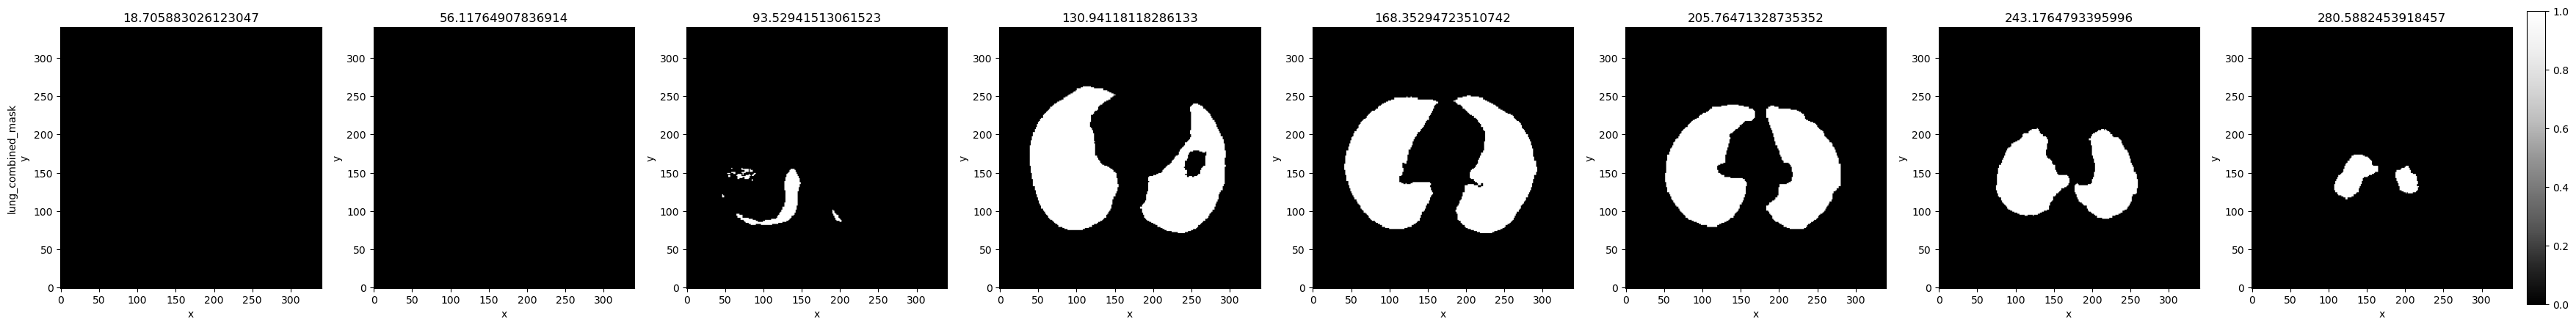

In [27]:
xview(masks[0][:1,:,:,16::32], cmap='Greys_r', vmin=0, vmax=1, col='z', row='roi', space=0.2)

In [20]:
%autoreload
disps = dataset[0][0].load_displacements(image_dir, disp_dir)
disps

../data/COPDGene/Images/10009Y/Phase-1/CorrField/10009Y_EXP_SHARP_NJC_COPD/10009Y_INSP_SHARP_NJC_COPD.nii.gz True
../data/COPDGene/Images/10009Y/Phase-1/CorrField/10009Y_EXP_STD_NJC_COPD/10009Y_INSP_STD_NJC_COPD.nii.gz True
../data/COPDGene/Images/10009Y/Phase-1/CorrField/10009Y_INSP_SHARP_NJC_COPD/10009Y_EXP_SHARP_NJC_COPD.nii.gz True
../data/COPDGene/Images/10009Y/Phase-1/CorrField/10009Y_INSP_STD_NJC_COPD/10009Y_EXP_STD_NJC_COPD.nii.gz True


[<xarray.DataArray '10009Y_EXP_SHARP_NJC_COPD' (mov_image_name: 1, x: 256,
                                                y: 256, z: 256, component: 3)> Size: 403MB
 array([[[[[ -5.74974394,  20.83345604, -32.03852081],
           [ -5.86159658,  20.83122253, -31.97860527],
           [ -5.97345066,  20.82899284, -31.91869354],
           ...,
           [-23.53556442, -10.31339359,   0.48266104],
           [-23.5219059 , -10.38676262,   0.66177827],
           [-23.50825119, -10.46012878,   0.8408913 ]],
 
          [[ -5.68092251,  21.0078373 , -32.01590347],
           [ -5.7915616 ,  21.00687218, -31.95598793],
           [ -5.90220213,  21.00590706, -31.8960743 ],
           ...,
           [-23.52248383, -10.19979191,   0.52757078],
           [-23.50871468, -10.27105045,   0.70763803],
           [-23.49494553, -10.34230614,   0.88770103]],
 
          [[ -5.61210108,  21.18221855, -31.99328423],
           [ -5.72152615,  21.18251991, -31.93336868],
           [ -5.83095312, 

In [22]:
disps[0].shape

(1, 256, 256, 256, 3)

In [29]:
masks[0].shape

(9, 256, 256, 256)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

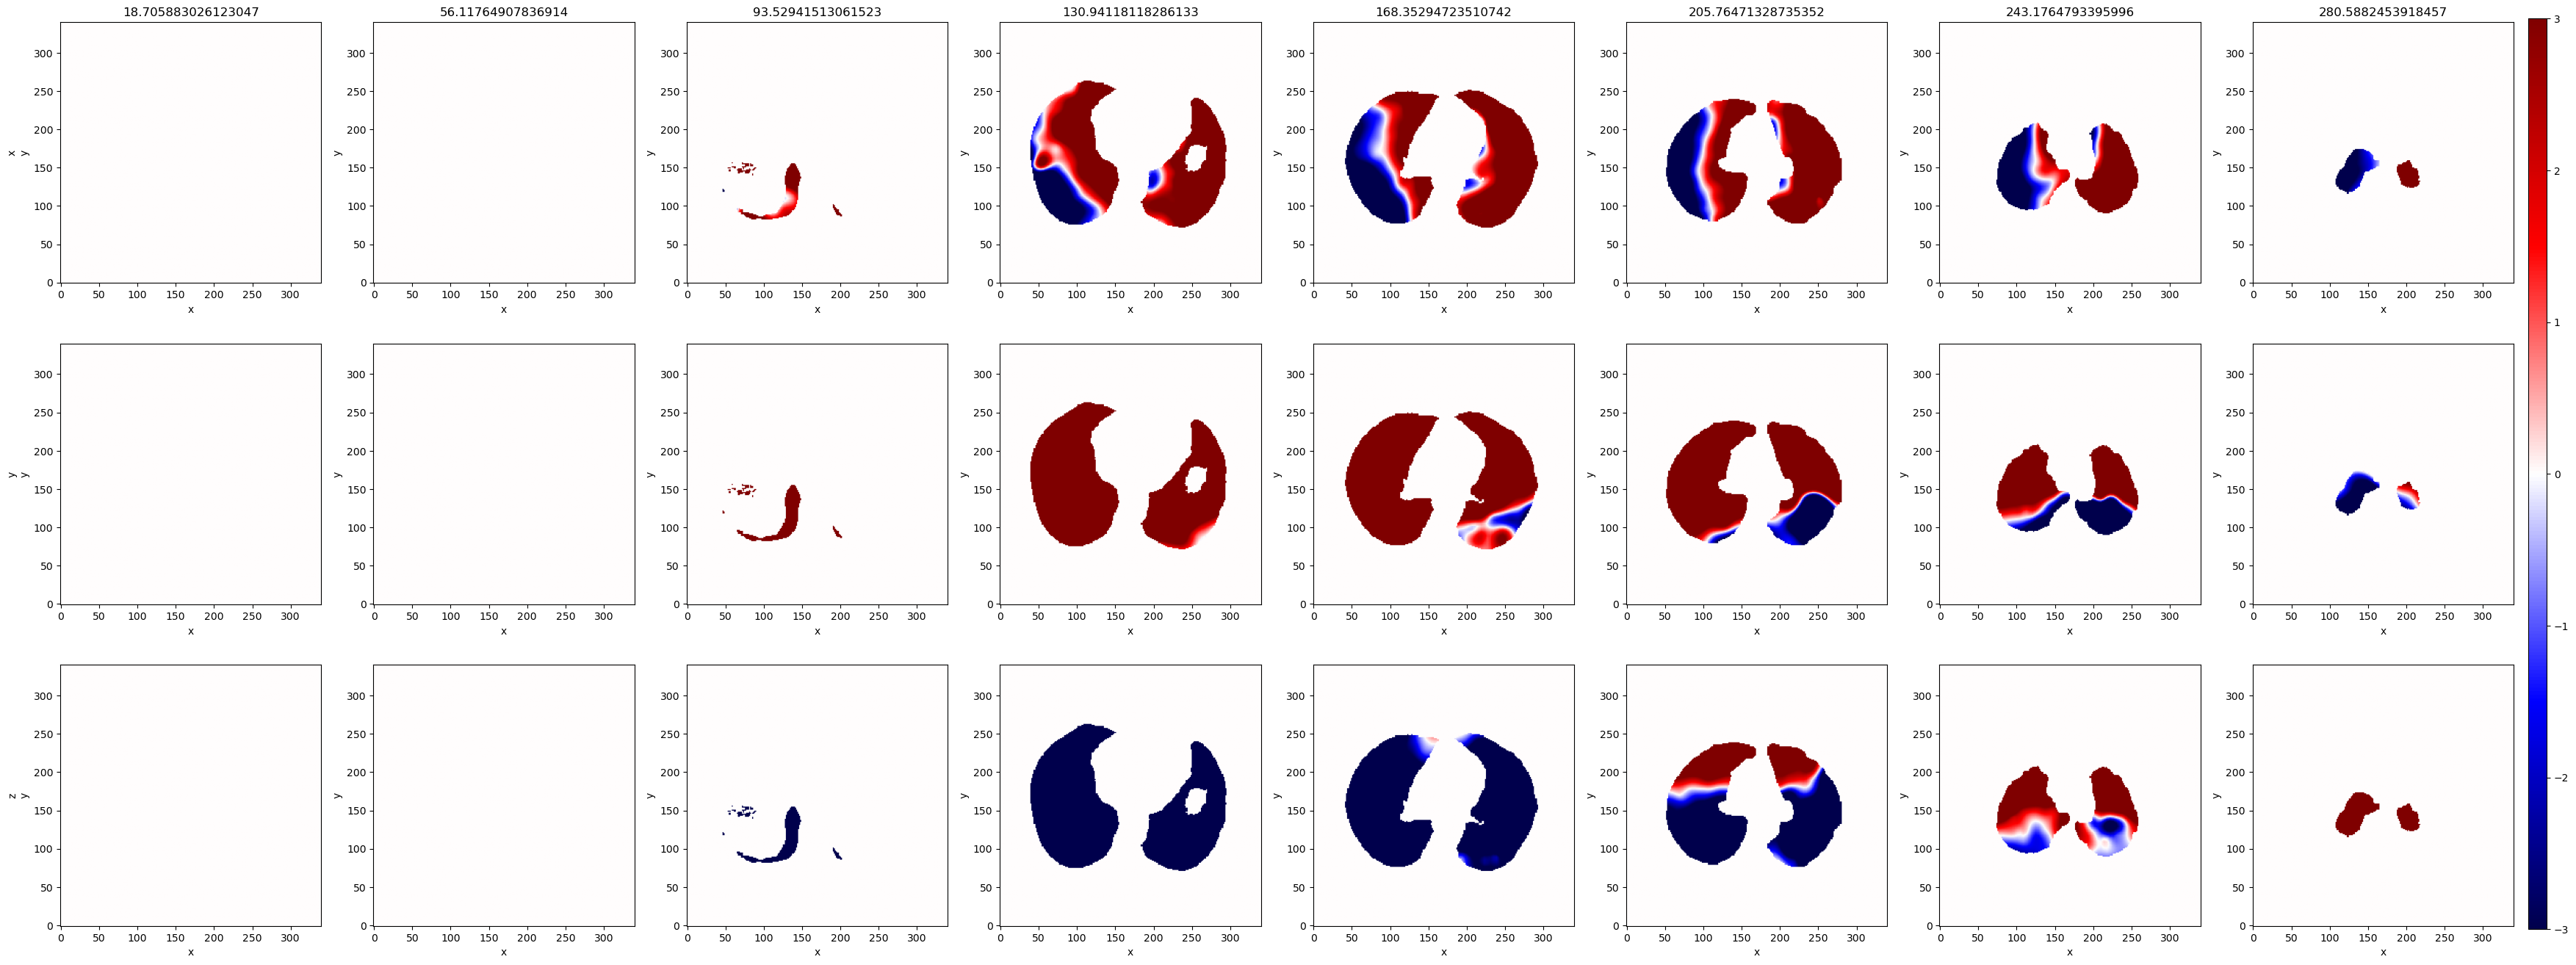

In [36]:
xview(disps[0][0,:,:,16::32,:] * masks[0][0,:,:,16::32], col='z', row='component', space=0.2)